# recommendation with surprise
- user to user

In [8]:
from sklearn.preprocessing import LabelEncoder
from bs4 import BeautifulSoup as bs
from pymongo import MongoClient
import urllib.request
import seaborn as sns
import pandas as pd
import numpy as np
import requests
import time
import re

In [9]:
client = MongoClient()

In [10]:
db = client.book_ratings

In [11]:
book_collection = db.book_collection

In [12]:
# declare a cursor
cursor_rating = db.book_collection.find({})

In [13]:
# make a dataframe from the cursor
rating_df =  pd.DataFrame(list(cursor_rating))

ServerSelectionTimeoutError: localhost:27017: [Errno 61] Connection refused

In [ ]:
rating_df.shape

In [ ]:
rating_df.columns

In [ ]:
# taking this out with make the index encoded (0,1,2,3…) instead of the user url
rating_df.index = rating_df['user']

In [ ]:
rating_df.head()

In [ ]:
# make a series with user assigned to anumber with book and rating
# drop 'user' and '_id'; they are going into surprise
rating_stack_df= rating_df.drop(columns=['_id', 'user']).stack() #['_id', 'user']).stack() # might drop both user and _id or just _id


In [ ]:
#turn series into a dataframe
rating_df_final = rating_stack_df.reset_index(name='rating')

In [ ]:
# # declare a cursor
# cursor_rating = db.collection.find({})

# # make a dataframe from the sursor
# rating_df =  pd.DataFrame(list(cursor_rating))

# # taking this out with make the index encoded (0,1,2,3…) instead of the user url
# rating_df.index = rating_df['user']

# # make a series with user assigned to anumber with book and rating
# # drop 'user' and '_id'; they are going into surprise
# rating_stack_df= rating_df.drop(columns=['_id', 'user']).stack() #['_id', 'user']).stack() # might drop both user and _id or just _id

# #turn series into a dataframe
# rating_df_final = rating_stack_df.reset_index(name='rating')



In [ ]:
rating_df_final.shape

In [7]:
rating_df_final.head()

NameError: name 'rating_df_final' is not defined

In [115]:
#fix the ratings
rating_df_final['rating'] = rating_df_final['rating'].apply(lambda x: float(x))

#rating_df_final['rating'] = rating_df_final['rating'].apply(lambda x: int(round(x)))

In [116]:
rating_df_final.shape

(39286, 3)

In [117]:
# take out all the duplicates
ratings_df_final = rating_df_final.drop_duplicates()

In [118]:
# check the shape again after dropping duplicates
ratings_df_final.shape

(20853, 3)

In [119]:
ratings_df_final.tail()

,user,level_1,rating
39281,/review/list/24957036-michael-anderson,/book/show/8227124-hazen-s-securities-regulati...,3.00
39282,/review/list/24957036-michael-anderson,/book/show/9912752-story-engineering,4.10
39283,/review/list/25052670-denise-webster,/book/show/13548945-fifty-one-shades,3.48
39284,/review/list/25052670-denise-webster,/book/show/25381870-the-authentic-sale,4.73
39285,/review/list/25052670-denise-webster,/book/show/25506521-the-authentic-sale,4.73


In [120]:
# reset the index, due to taking out the duplicates
ratings_df_final = ratings_df_final.reset_index(drop=True)

In [121]:
ratings_df_final.tail()

,user,level_1,rating
20848,/review/list/24957036-michael-anderson,/book/show/8227124-hazen-s-securities-regulati...,3.00
20849,/review/list/24957036-michael-anderson,/book/show/9912752-story-engineering,4.10
20850,/review/list/25052670-denise-webster,/book/show/13548945-fifty-one-shades,3.48
20851,/review/list/25052670-denise-webster,/book/show/25381870-the-authentic-sale,4.73
20852,/review/list/25052670-denise-webster,/book/show/25506521-the-authentic-sale,4.73


In [122]:
ratings_df_final = ratings_df_final.rename(index=str, columns={"level_1": "book"})

In [123]:
ratings_df_final.head()

,user,book,rating
0,/review/list/4166936-cora-tea-party-princess,/book/show/18332131-a-dark-and-twisted-tide,3.94
1,/review/list/4166936-cora-tea-party-princess,/book/show/18522304-silencing-sapphire,4.16
2,/review/list/4166936-cora-tea-party-princess,/book/show/18522351-the-colour-of-magic,3.99
3,/review/list/4166936-cora-tea-party-princess,/book/show/18525289-gibside,5.00
4,/review/list/4166936-cora-tea-party-princess,/book/show/18657686-war-girls,3.81


In [189]:
ratings_df_final.to_csv('csv_files/book_ratings.csv', encoding='utf-8', index=False)

In [124]:
type(rating_df_final.duplicated())

pandas.core.series.Series

# Need some EDA on the data

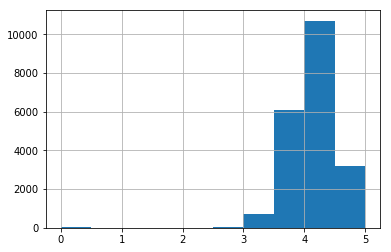

In [125]:
# here
ratings_df_final['rating'].hist()

In [126]:
ratings_df_final.nunique()

user       1448
book      17536
rating      235
dtype: int64

In [128]:
top_rated = ratings_df_final.groupby('book').count().sort_values('user', ascending=False)[:40] #['bookRating'].count().reset_index().sort_values('bookRating', ascending=False)[:10]


In [129]:
top_rated = top_rated.drop(columns='user')

In [130]:
# graph this
top_rated.head(10)

,rating
book,
/book/show/2767052-the-hunger-games,125
/book/show/6148028-catching-fire,40
/book/show/13335037-divergent,39
/book/show/11870085-the-fault-in-our-stars,37
/book/show/22557272-the-girl-on-the-train,36
/book/show/17899948-rebecca,32
/book/show/7260188-mockingjay,31
/book/show/12232938-the-lovely-bones,31
/book/show/17470674-fahrenheit-451,29


# Get the genre for the books

In [192]:
# set up new collection
book_genres = db.book_genres

In [143]:
book_url_list = ratings_df_final['book'].tolist()

In [174]:
len(book_url_list)

20853

In [176]:
book_url_list_set = list(set(book_url_list))

In [177]:
len(book_url_list_set)

17536

In [184]:
book_url_list_set[2:25]

['/book/show/26013318-craved',
 '/book/show/23007718-oliver-and-jumpy-stories-10-12',
 '/book/show/31200537-blind-side',
 '/book/show/16032538-the-midnight-promise',
 '/book/show/30109231-jack-of-thorns',
 '/book/show/2941255-lucky-me',
 '/book/show/30201752-daughter-of-winter',
 '/book/show/16130619-never-say-never',
 '/book/show/43090698-atelier-of-witch-hat-vol-3',
 '/book/show/31817749-the-stone-sky',
 '/book/show/36722910-a-purgatory-of-misery',
 '/book/show/18665259-picture-perfect',
 '/book/show/42388720-whispers-in-the-dark',
 '/book/show/34751082-the-negotiator',
 '/book/show/18396834-sex-and-the-single-christian-girl',
 '/book/show/16056974-the-hidden-tools-of-comedy',
 '/book/show/23281906-the-liar',
 '/book/show/28650169-enemy-of-my-enemy',
 '/book/show/28855904-secrets-revealed-for-getting-the-best-website-traffic',
 '/book/show/3918010-kick-ass',
 '/book/show/23552461-the-dangerous-love-of-a-rogue',
 '/book/show/23364977-the-girl-on-the-train',
 '/book/show/25558451-spook

In [154]:
bb = book_url_list[:3]

In [193]:
# get genres from all books
def get_genre(soup):
    book_url = f'https://www.goodreads.com{soup}'
    book_r = urllib.request.urlopen(book_url)
    book_soup = bs(book_r, 'html.parser')
    try:
        book_genre = book_soup.find('a', {'class': 'actionLinkLite bookPageGenreLink'}, href=True).text
    except:
        book_genre = None
    genre_dict = {soup:book_genre}
    # return a dictionary to put in a mongo collection
    return genre_dict


In [289]:
# pass in a list of user urls
def get_book_genre(book_url_lists):
    genre = []
    for book in book_url_lists:
        first_book_genre = get_genre(book)
        time.sleep(.8)
        print(book)
        genre.append(first_book_genre)
        results = book_genres.insert_one(first_book_genre)
    return genre

In [205]:
genre_1 = get_book_genre(book_url_list_set[:2])
genre_1

/Users/roberthillery/anaconda3/envs/books/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: insert is deprecated. Use insert_one or insert_many instead.
  


[{'/book/show/26047357-the-cardinal-s-sin': 'Mystery',
  '_id': ObjectId('5c5863d00695eb1217b4adb8')},
 {'/book/show/36863463-tall-chimneys': 'Historical',
  '_id': ObjectId('5c5863d30695eb1217b4adb9')}]

In [187]:
genre_2 = get_book_genre(book_url_list_set[2:25])
genre_2

[{'/book/show/26013318-craved': 'Dark',
  '_id': ObjectId('5c585fbb0695eb1217b4ad4d')},
 {'/book/show/23007718-oliver-and-jumpy-stories-10-12': 'Childrens',
  '_id': ObjectId('5c585fbb0695eb1217b4ad4e')},
 {'/book/show/31200537-blind-side': 'Thriller',
  '_id': ObjectId('5c585fbb0695eb1217b4ad4f')},
 {'/book/show/16032538-the-midnight-promise': 'Fiction',
  '_id': ObjectId('5c585fbb0695eb1217b4ad50')},
 {'/book/show/30109231-jack-of-thorns': 'Romance',
  '_id': ObjectId('5c585fbb0695eb1217b4ad51')},
 {'/book/show/2941255-lucky-me': None,
  '_id': ObjectId('5c585fbb0695eb1217b4ad52')},
 {'/book/show/30201752-daughter-of-winter': 'Fantasy',
  '_id': ObjectId('5c585fbb0695eb1217b4ad53')},
 {'/book/show/16130619-never-say-never': 'Christian Fiction',
  '_id': ObjectId('5c585fbb0695eb1217b4ad54')},
 {'/book/show/43090698-atelier-of-witch-hat-vol-3': 'Sequential Art',
  '_id': ObjectId('5c585fbb0695eb1217b4ad55')},
 {'/book/show/31817749-the-stone-sky': 'Fantasy',
  '_id': ObjectId('5c585fbb

In [188]:
genre_3 = get_book_genre(book_url_list_set[25:100])
genre_3

[{'/book/show/9528186-pretty-little-liars': 'Young Adult',
  '_id': ObjectId('5c5861620695eb1217b4ad64')},
 {'/book/show/18594501-take-back-the-skies': 'Young Adult',
  '_id': ObjectId('5c5861620695eb1217b4ad65')},
 {'/book/show/23844254-the-invisible-library': 'Fantasy',
  '_id': ObjectId('5c5861620695eb1217b4ad66')},
 {'/book/show/11250317-the-song-of-achilles': 'Historical',
  '_id': ObjectId('5c5861620695eb1217b4ad67')},
 {'/book/show/29912605-seeds-of-love': 'Romance',
  '_id': ObjectId('5c5861620695eb1217b4ad68')},
 {'/book/show/34185977-desert-thieves': 'Science Fiction',
  '_id': ObjectId('5c5861620695eb1217b4ad69')},
 {'/book/show/36647568-the-truth-seeker-s-handbook': 'Science',
  '_id': ObjectId('5c5861620695eb1217b4ad6a')},
 {'/book/show/17131800-hunt-for-the-devil-s-dragon': 'Christian',
  '_id': ObjectId('5c5861620695eb1217b4ad6b')},
 {'/book/show/3001512-wesley-the-owl': 'Nonfiction',
  '_id': ObjectId('5c5861620695eb1217b4ad6c')},
 {'/book/show/35001204-the-girl-who-tal

In [207]:
genre_4 = get_book_genre(book_url_list_set[100:500])
genre_4

/Users/roberthillery/anaconda3/envs/books/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: insert is deprecated. Use insert_one or insert_many instead.
  


[{'/book/show/18831214-travel-resolutions': 'Travel',
  '_id': ObjectId('5c58644c0695eb1217b4adba')},
 {'/book/show/34737063-prophecy-awakened': 'Fantasy',
  '_id': ObjectId('5c58644f0695eb1217b4adbb')},
 {'/book/show/39320656-the-map-of-us': 'Fiction',
  '_id': ObjectId('5c5864540695eb1217b4adbc')},
 {'/book/show/38140077-washington-black': 'Historical',
  '_id': ObjectId('5c5864580695eb1217b4adbd')},
 {'/book/show/15852847-wool': 'Science Fiction',
  '_id': ObjectId('5c5864600695eb1217b4adbe')},
 {'/book/show/32623877-the-unhappy-wife': None,
  '_id': ObjectId('5c5864630695eb1217b4adbf')},
 {'/book/show/20697435-the-book-of-strange-new-things': 'Fiction',
  '_id': ObjectId('5c5864690695eb1217b4adc0')},
 {'/book/show/23740830-the-all-souls-trilogy-boxed-set': 'Fantasy',
  '_id': ObjectId('5c58646d0695eb1217b4adc1')},
 {'/book/show/3323157-children-s-songbook': 'Religion',
  '_id': ObjectId('5c5864720695eb1217b4adc2')},
 {'/book/show/17972617-the-price-of-ascendance': 'Science Fiction'

In [209]:
genre_5 = get_book_genre(book_url_list_set[500:1000])
genre_5

[{'/book/show/38111877-dark-of-night': 'Fantasy',
  '_id': ObjectId('5c586b070695eb1217b4af4a')},
 {'/book/show/22078125-even-legends-die': 'Science Fiction',
  '_id': ObjectId('5c586b0d0695eb1217b4af4b')},
 {'/book/show/7669259-everfound': 'Fantasy',
  '_id': ObjectId('5c586b130695eb1217b4af4c')},
 {'/book/show/28014095-omert': 'Romance',
  '_id': ObjectId('5c586b170695eb1217b4af4d')},
 {'/book/show/17169111-curious-warnings': 'Horror',
  '_id': ObjectId('5c586b1a0695eb1217b4af4e')},
 {'/book/show/32715682-lucid-umbra-people': 'Horror',
  '_id': ObjectId('5c586b1e0695eb1217b4af4f')},
 {'/book/show/28483277-beyond-the-horizon': 'Science Fiction',
  '_id': ObjectId('5c586b230695eb1217b4af50')},
 {'/book/show/6470037-library-of-the-dead': 'Thriller',
  '_id': ObjectId('5c586b280695eb1217b4af51')},
 {'/book/show/35909574-lainie-s-ladies': None,
  '_id': ObjectId('5c586b2a0695eb1217b4af52')},
 {'/book/show/24402017-from-the-ashes': 'Fantasy',
  '_id': ObjectId('5c586b2e0695eb1217b4af53')},

In [210]:
genre_6 = get_book_genre(book_url_list_set[1000:2000])
genre_6

[{'/book/show/25806035-beast-blood': None,
  '_id': ObjectId('5c5873370695eb1217b4b13e')},
 {'/book/show/18685442-getting-a-life': None,
  '_id': ObjectId('5c58733a0695eb1217b4b13f')},
 {'/book/show/9375959-dr-horrible-and-other-horrible-stories': 'Sequential Art',
  '_id': ObjectId('5c58733d0695eb1217b4b140')},
 {'/book/show/30365676-the-journey-of-peter-mccall': None,
  '_id': ObjectId('5c5873410695eb1217b4b141')},
 {'/book/show/37541303-one-apocalypse': 'Polyamorous',
  '_id': ObjectId('5c5873440695eb1217b4b142')},
 {'/book/show/17225311-tampa': 'Fiction',
  '_id': ObjectId('5c5873480695eb1217b4b143')},
 {'/book/show/34627540-empty-threat': 'Fantasy',
  '_id': ObjectId('5c58734e0695eb1217b4b144')},
 {'/book/show/30745729-granted': 'Fantasy',
  '_id': ObjectId('5c5873540695eb1217b4b145')},
 {'/book/show/26228189-silent-melody': 'Romance',
  '_id': ObjectId('5c5873590695eb1217b4b146')},
 {'/book/show/25678110-fresh-hell': 'Womens Fiction',
  '_id': ObjectId('5c58735e0695eb1217b4b147')

In [211]:
genre_7 = get_book_genre(book_url_list_set[2000:5000])
genre_7

[{'/book/show/7074000-happy-ever-after': 'Romance',
  '_id': ObjectId('5c58845c0695eb1217b4b526')},
 {'/book/show/35498531-ethan': 'Romance',
  '_id': ObjectId('5c5884620695eb1217b4b527')},
 {'/book/show/28113975-the-merlin-and-the-damsel': None,
  '_id': ObjectId('5c5884660695eb1217b4b528')},
 {'/book/show/30339479-you-ll-miss-me-when-i-m-gone': 'Contemporary',
  '_id': ObjectId('5c58846a0695eb1217b4b529')},
 {'/book/show/36383244-the-duke-of-ruin': 'Romance',
  '_id': ObjectId('5c5884700695eb1217b4b52a')},
 {'/book/show/32311590-good-morning-chickalina': None,
  '_id': ObjectId('5c5884730695eb1217b4b52b')},
 {'/book/show/7831435-the-amulet-of-samarkand': 'Fantasy',
  '_id': ObjectId('5c5884770695eb1217b4b52c')},
 {'/book/show/17250961-oathbringer': 'Fantasy',
  '_id': ObjectId('5c58847c0695eb1217b4b52d')},
 {'/book/show/6239462-ship-of-rome': 'Historical',
  '_id': ObjectId('5c5884800695eb1217b4b52e')},
 {'/book/show/25877415-enter-the-janitor': 'Fantasy',
  '_id': ObjectId('5c588485

In [290]:
genre_half_7 = get_book_genre(book_url_list_set[5000:5100])
genre_half_7

/book/show/32615132-serenity
/book/show/22081482-firecross
/book/show/25049976-stealing-home
/book/show/33122918-the-girl-and-the-clockwork-cat
/book/show/28152217-holiday-heartwarmers
/book/show/23164983-hollow-city
/book/show/38899420-this-darkness-got-to-give
/book/show/29780253-born-a-crime
/book/show/33141239-the-impossible-fortress
/book/show/26155841-mixing-temptation
/book/show/13154952-calico-joe
/book/show/39828741-heart-of-the-deep
/book/show/35777443-triangulation
/book/show/18214414-the-silkworm
/book/show/32610720-fire-and-glass
/book/show/34874212-splintered-souls
/book/show/25283833-boundary-lines
/book/show/26530389-idiot-brain
/book/show/36621227-want-me
/book/show/36362101-scented
/book/show/8620132-cinders
/book/show/23274204-quest-for-sleeping-handsome
/book/show/34709486-parents-survival-guide-to-online-safety---cell-phone-monitoring-gps-t
/book/show/25767849-logan
/book/show/27302333-vatic
/book/show/29763160-lust-and-lies
/book/show/24356703-memory-man
/book/sho

[{'/book/show/32615132-serenity': 'Thriller',
  '_id': ObjectId('5c5aeb5b0695eb1217b4d0fe')},
 {'/book/show/22081482-firecross': None,
  '_id': ObjectId('5c5aeb5e0695eb1217b4d0ff')},
 {'/book/show/25049976-stealing-home': None,
  '_id': ObjectId('5c5aeb610695eb1217b4d100')},
 {'/book/show/33122918-the-girl-and-the-clockwork-cat': 'Science Fiction',
  '_id': ObjectId('5c5aeb660695eb1217b4d101')},
 {'/book/show/28152217-holiday-heartwarmers': 'Romance',
  '_id': ObjectId('5c5aeb690695eb1217b4d102')},
 {'/book/show/23164983-hollow-city': 'Fantasy',
  '_id': ObjectId('5c5aeb6d0695eb1217b4d103')},
 {'/book/show/38899420-this-darkness-got-to-give': None,
  '_id': ObjectId('5c5aeb710695eb1217b4d104')},
 {'/book/show/29780253-born-a-crime': 'Nonfiction',
  '_id': ObjectId('5c5aeb760695eb1217b4d105')},
 {'/book/show/33141239-the-impossible-fortress': 'Fiction',
  '_id': ObjectId('5c5aeb7b0695eb1217b4d106')},
 {'/book/show/26155841-mixing-temptation': 'Romance',
  '_id': ObjectId('5c5aeb840695eb

In [293]:
genre_8 = get_book_genre(book_url_list_set[5100:5500])
genre_8

/book/show/25846418-danger-at-thatcham-hall
/book/show/23533039-ancillary-mercy
/book/show/36573436-the-common-girl
/book/show/36520261-feast
/book/show/22957237-red-dirt-heart-2
/book/show/24019187-humans-of-new-york
/book/show/40222505-the-squad
/book/show/22739690-a-saucy-murder
/book/show/24866809-fantasy-of-flight
/book/show/20895196-mr-mercedes
/book/show/16595092-doha-12
/book/show/36463883-the-children-s-wonder-book
/book/show/20823743-the-vampire-seduction-iii
/book/show/24882385-the-rub-down
/book/show/11471977-matthew-reilly-collection
/book/show/19517054-shard-knight
/book/show/30283540-a-year-and-a-day
/book/show/24647548-redemption
/book/show/8675283-vanished-kingdoms
/book/show/23003301-god-is-a-gamer
/book/show/24145817
/book/show/13414713-vision-for-life
/book/show/40580313-front-page-fatality
/book/show/23190986-edge-of-eternity
/book/show/36593216-fractured
/book/show/20341402-alinor-s-shard
/book/show/6062060-stray
/book/show/18297707-tangled
/book/show/9560856-the-

/book/show/27413948-the-joy-of-argument
/book/show/20317032-holistic-and-practical-support-for-alzheimer-s-caregivers
/book/show/3299422-isola
/book/show/38136877-an-easy-death
/book/show/30221796-ripples-in-the-pond
/book/show/23637766-house-of-apache-fires
/book/show/7117190-500-low-cholesterol-recipes
/book/show/30962267-the-ghostwriter
/book/show/10917460-yotsuba-vol-10
/book/show/30654322-mummy-s-favourite
/book/show/17208562-just-a-little-sincerity
/book/show/33559635-a-mother-s-snowflake
/book/show/37647832-a-calliope-crow-christmas
/book/show/18160387-and-one-makes-three
/book/show/13246071-little-prisoners
/book/show/24197500-the-psychology-of-the-mind-and-body
/book/show/12513614-captive-in-the-dark
/book/show/16084702-fifty-shades-duo
/book/show/22838592-florence-and-me
/book/show/34396263-a-light-in-the-dark
/book/show/30737085-the-lively-library-an-unlikely-romance
/book/show/17283332-hide-in-time
/book/show/34569999-bible-promises-to-live-by-for-women
/book/show/38644409-

[{'/book/show/25846418-danger-at-thatcham-hall': 'Mystery',
  '_id': ObjectId('5c5b07f90695eb1217b4d3f1')},
 {'/book/show/23533039-ancillary-mercy': 'Science Fiction',
  '_id': ObjectId('5c5b07ff0695eb1217b4d3f2')},
 {'/book/show/36573436-the-common-girl': 'Romance',
  '_id': ObjectId('5c5b08030695eb1217b4d3f3')},
 {'/book/show/36520261-feast': 'Autobiography',
  '_id': ObjectId('5c5b08070695eb1217b4d3f4')},
 {'/book/show/22957237-red-dirt-heart-2': 'Romance',
  '_id': ObjectId('5c5b080c0695eb1217b4d3f5')},
 {'/book/show/24019187-humans-of-new-york': 'Nonfiction',
  '_id': ObjectId('5c5b08100695eb1217b4d3f6')},
 {'/book/show/40222505-the-squad': None,
  '_id': ObjectId('5c5b08140695eb1217b4d3f7')},
 {'/book/show/22739690-a-saucy-murder': 'Mystery',
  '_id': ObjectId('5c5b08190695eb1217b4d3f8')},
 {'/book/show/24866809-fantasy-of-flight': 'Fantasy',
  '_id': ObjectId('5c5b089b0695eb1217b4d3f9')},
 {'/book/show/20895196-mr-mercedes': 'Fiction',
  '_id': ObjectId('5c5b08a70695eb1217b4d3fa

In [295]:
genre_9 = get_book_genre(book_url_list_set[5500:6000])
genre_9

/book/show/28468816-revenge-of-cornelius
/book/show/12524282-the-traitor
/book/show/23019294-a-head-full-of-ghosts
/book/show/41252658-the-white-bench
/book/show/33030707-fierce-lover
/book/show/18240500-the-unpredictable-consequences-of-love
/book/show/38102484-undertow
/book/show/8135690-the-memoirs-of-sherlock-holmes
/book/show/42088060-la-petite-voix
/book/show/18640739-acts-of-contrition
/book/show/25482007-with-visions-of-red
/book/show/26792871-bullies-ghosts-and-jars-full-of-smoke
/book/show/23507069-a-twin-s-redemption
/book/show/37561920-le-sang-des-anges
/book/show/30255928-the-men-in-my-life
/book/show/34178759-loving-luther
/book/show/41123266-prae-lium
/book/show/30637470-witness
/book/show/17142100-may-we-be-forgiven
/book/show/7016543-anything-goes
/book/show/30737400-galba-s-men
/book/show/43191533-the-confederate
/book/show/33113463-hunting-savage
/book/show/15778794-it-takes-15-minutes-to-change-your-life
/book/show/13450339-poison-princess
/book/show/17668133-writin

/book/show/36444507-never-look-back
/book/show/18949650-the-bone-clocks
/book/show/7600129-the-beatles
/book/show/41306361-toil-trouble
/book/show/32594606-the-scattered-flock
/book/show/16029043-the-one-you-love
/book/show/32993979-the-devil-the-witch-and-the-whore
/book/show/18802060-the-defiant-governess
/book/show/40617133-alpha-king
/book/show/24568119-player
/book/show/33283226-taken
/book/show/17333289-operation-paperclip
/book/show/36441669-station-zero
/book/show/29003584-the-lady-of-the-tower
/book/show/23162904-pearseus-bundle
/book/show/8176988-passage-to-dawn
/book/show/34935490-the-steampunk-electric-puppy
/book/show/32060230-oscar-s-night
/book/show/13598534-the-sign-of-the-eagle
/book/show/25940026-universe-earth
/book/show/20510868-big-little-lies
/book/show/8486370-macbeth
/book/show/21078549-all-the-gods-of-eisernon
/book/show/19437184-mythed-connections
/book/show/15838590-scrivener-for-dummies
/book/show/19888214-the-canarsie-flash
/book/show/26887738-the-truth
/bo

/book/show/35801397-the-elusive-pimpernel
/book/show/25370209-itchy-little-feet-namibia
/book/show/8124176-play-their-hearts-out
/book/show/23349235-freakonomics
/book/show/23272172-kings-of-delusion
/book/show/40807477-love-on-the-half-shell
/book/show/36436893-empty-before-you
/book/show/4130984-agaton-sax-and-the-london-computer-plot
/book/show/28246848-a-sereia
/book/show/5585788-skinwalker
/book/show/34391822-in-what-remains
/book/show/18079163-4
/book/show/2692931-castner-s-cutthroats
/book/show/31820291-our-justice
/book/show/18136617-cast-in-flame
/book/show/8176622-the-breastfeeding-mother-s-guide-to-making-more-milk
/book/show/40385766-the-dark-witch-and-the-elemental
/book/show/18368876-shot-on-location
/book/show/40027924-scorn-of-the-sky-goddess
/book/show/31948041-pearl-of-the-seas
/book/show/25398324-the-hunter
/book/show/25364361-life-lessons-by-year
/book/show/17262100-the-lowland
/book/show/18103922-conan-the-cimmerian
/book/show/5119357-scarred
/book/show/25541556-th

[{'/book/show/28468816-revenge-of-cornelius': None,
  '_id': ObjectId('5c5b27200695eb1217b4d747')},
 {'/book/show/12524282-the-traitor': None,
  '_id': ObjectId('5c5b27220695eb1217b4d748')},
 {'/book/show/23019294-a-head-full-of-ghosts': 'Horror',
  '_id': ObjectId('5c5b27280695eb1217b4d749')},
 {'/book/show/41252658-the-white-bench': 'Horror',
  '_id': ObjectId('5c5b272a0695eb1217b4d74a')},
 {'/book/show/33030707-fierce-lover': None,
  '_id': ObjectId('5c5b272e0695eb1217b4d74b')},
 {'/book/show/18240500-the-unpredictable-consequences-of-love': 'Womens Fiction',
  '_id': ObjectId('5c5b27330695eb1217b4d74c')},
 {'/book/show/38102484-undertow': 'Fantasy',
  '_id': ObjectId('5c5b27370695eb1217b4d74d')},
 {'/book/show/8135690-the-memoirs-of-sherlock-holmes': 'Mystery',
  '_id': ObjectId('5c5b27400695eb1217b4d74e')},
 {'/book/show/42088060-la-petite-voix': 'Fiction',
  '_id': ObjectId('5c5b27450695eb1217b4d74f')},
 {'/book/show/18640739-acts-of-contrition': 'Fiction',
  '_id': ObjectId('5c5

In [296]:
genre_10 = get_book_genre(book_url_list_set[6000:6500])
genre_10

/book/show/29981261-the-butterfly-garden
/book/show/12180581-switched
/book/show/22570784-clash-of-eagles
/book/show/20328471-secret-vaults-of-time
/book/show/42141665-twisted-emotions
/book/show/40849541-scrum-a-startup-enxuta---kit-exclusivo-com-2-volumes
/book/show/38912079-missing-and-presumed-dead
/book/show/3401640-kill-for-me
/book/show/16081272-the-edge-of-never
/book/show/25335124-the-secret-rahasya
/book/show/15798309-limitless
/book/show/16050911-beast
/book/show/36268552-the-son-of-alpha
/book/show/21871899-the-night-of-elisa
/book/show/25398353-the-witch-of-lime-street
/book/show/30834434-love-is-more-than-skin-deep
/book/show/18687191-the-firedragon
/book/show/42330707-good-morning-mr-sh-ttybottom
/book/show/8117586-into-the-wild
/book/show/36478832-let-s-make-soap
/book/show/33539583-munich
/book/show/17396977-confucius-on-leadership
/book/show/19359213-deep-secrets
/book/show/18379323-the-addiction-treatment-planner
/book/show/40280927-dragon-song
/book/show/17226279-af

/book/show/35560168-breaking-spirits
/book/show/20976362-done-deal
/book/show/18629197-18
/book/show/23148126-warranty-work
/book/show/20877523-not-the-phoenix-cycle-nope
/book/show/3506012-persuasion
/book/show/22571629-the-architect-s-apprentice
/book/show/18921809-inky
/book/show/33799670-drunk-in-love
/book/show/29761093-the-magic-leaf
/book/show/35595869-the-best-man
/book/show/35657376-virginia-woolf
/book/show/24378015-never-never
/book/show/33905006-when-i-hit-you
/book/show/35399019-the-story-works-guide-to-writing-point-of-view
/book/show/35433584-rising-the-beast
/book/show/12454671-boss-bitch
/book/show/6565600-black-frost
/book/show/20007633-the-gunslinger
/book/show/27131005-echoes-of-tattered-tongues
/book/show/23447506-when-the-moon-is-low
/book/show/3517649-the-vestibule
/book/show/16158596-lexicon
/book/show/36295112-she-was-born-a-good-girl
/book/show/17857998-manic
/book/show/23120107-carnival-of-the-damned
/book/show/31450852-tower-of-dawn
/book/show/31931941-eliza

/book/show/32544327-george-bailey-gets-saved-in-the-end
/book/show/25627029-prisoner-of-the-minotaur
/book/show/27990806-a-new-baby-for-christmas
/book/show/17876893-captivated-by-you
/book/show/25943544-edge-of-darkness
/book/show/6425289-fairy-tales-from-the-arabian-nights
/book/show/37849452-disorder
/book/show/20797476-inside-of-you
/book/show/40875657-after-the-last-battle
/book/show/20897517-in-the-kingdom-of-ice
/book/show/8573632-the-way-we-fall
/book/show/30618770-out-of-the-inferno
/book/show/43505526-a-perfect-memory
/book/show/11479285-breathe
/book/show/29493158-big-red-firetruck
/book/show/35440486-the-mac-brothers-series
/book/show/18804899-the-beach-hut-next-door
/book/show/35840657-heart-berries
/book/show/25775707-small-wars
/book/show/16030817-empower
/book/show/15865482-the-world-naked-bike-ride
/book/show/36414596-deep-state
/book/show/26595159-the-ninja-and-the-diplomat
/book/show/11208523-sir-gawain-and-the-green-knight-barnes-noble-digital-library
/book/show/302

[{'/book/show/29981261-the-butterfly-garden': 'Thriller',
  '_id': ObjectId('5c5b314d0695eb1217b4d93b')},
 {'/book/show/12180581-switched': 'Fantasy',
  '_id': ObjectId('5c5b31520695eb1217b4d93c')},
 {'/book/show/22570784-clash-of-eagles': 'Historical',
  '_id': ObjectId('5c5b31580695eb1217b4d93d')},
 {'/book/show/20328471-secret-vaults-of-time': 'Nonfiction',
  '_id': ObjectId('5c5b315c0695eb1217b4d93e')},
 {'/book/show/42141665-twisted-emotions': 'Romance',
  '_id': ObjectId('5c5b31610695eb1217b4d93f')},
 {'/book/show/40849541-scrum-a-startup-enxuta---kit-exclusivo-com-2-volumes': None,
  '_id': ObjectId('5c5b31640695eb1217b4d940')},
 {'/book/show/38912079-missing-and-presumed-dead': 'Romance',
  '_id': ObjectId('5c5b31680695eb1217b4d941')},
 {'/book/show/3401640-kill-for-me': 'Romance',
  '_id': ObjectId('5c5b316d0695eb1217b4d942')},
 {'/book/show/16081272-the-edge-of-never': 'Romance',
  '_id': ObjectId('5c5b31770695eb1217b4d943')},
 {'/book/show/25335124-the-secret-rahasya': 'Self

In [297]:
genre_11 = get_book_genre(book_url_list_set[6500:7000])
genre_11

/book/show/26870079-guardian-of-the-silverwood
/book/show/10485566-next-of-kin
/book/show/27259467-melissa-dedomenico-payne
/book/show/18213009-fix-you
/book/show/9021894-the-making-of-the-empire-strikes-back
/book/show/26045643-lady-sun
/book/show/6493208-the-immortal-life-of-henrietta-lacks
/book/show/29750725-at-work-within
/book/show/32606677-the-last-treasure-of-ancient-england
/book/show/21030361-strange-tales-of-the-sea
/book/show/34875752-winter-s-exile
/book/show/20764085-love-lift-me
/book/show/14060350-strictly-murder
/book/show/25953203-poveglia
/book/show/17325907-xenophon-on-horsemanship
/book/show/43315643-a-gift-for-elizabeth
/book/show/28500062-cosmic-callisto-caprica-the-missing-rings-of-saturn
/book/show/14061955-siege-and-storm
/book/show/29485017-angels-and-man-beasts
/book/show/25680209-taming-the-trouser-snake
/book/show/8703801-king-of-the-desert-captive-bride
/book/show/23866413-dim-sum-dead-some
/book/show/10182483-all-about-words
/book/show/6333237-sputnik-me

/book/show/26226507-the-icarus-prediction
/book/show/35658772-the-grimhaven-disaster
/book/show/18872437-the-millionaire-fastlane
/book/show/18765614-rowan-s-lady
/book/show/6979037-anything-but-normal
/book/show/24945230-before-it-breaks
/book/show/5217282-secrets-of-the-dragon-sanctuary
/book/show/29429246-death-comes-to-the-fair
/book/show/30980783-sheikh-s-revenge
/book/show/13557703-fifty-shades-of-grey
/book/show/39327492-feral
/book/show/23253597-shameless
/book/show/12359808-it-s-a-waverly-life
/book/show/29760879-the-recipient
/book/show/6828896-delivering-happiness
/book/show/27248808-the-mince-pie-mix-up
/book/show/21469053-stone-in-the-sky
/book/show/6352731-the-odyssey
/book/show/25973203-minecraft
/book/show/7576115-i-shall-wear-midnight
/book/show/6265683-the-mysterious-island
/book/show/17295139-easy-bake-coven
/book/show/23489287-eleven-twelve-dig-and-delve
/book/show/23269284-horizon
/book/show/22441327-a-teacher-s-guide-to-the-alchemist
/book/show/39976413-where-can-

/book/show/40517884-the-dreamcatchers
/book/show/18144590-the-alchemist
/book/show/18339649-debbie-doesn-t-do-it-anymore
/book/show/26215029-spirit-of-the-wind
/book/show/18138917-trouble
/book/show/35099112-genshiken
/book/show/11509894-countdown
/book/show/9422469-the-horse-and-his-boy
/book/show/25517851-cannon
/book/show/40188352-killing-the-unicorn
/book/show/6089025-patches-of-grey
/book/show/32620890-hag-s-breath
/book/show/16109080-an-innocent-client
/book/show/41055273-what-i-didn-t-say
/book/show/35670643-penguins-and-mortal-peril
/book/show/9912994-damned
/book/show/36350494-the-simple-soul-of-susan
/book/show/30215327-the-dueling-pianos-murder
/book/show/18085117-the-man-of-gold
/book/show/3294622-shinobi-life-vol-01
/book/show/27838211-eighteen
/book/show/35452261-on-waves-of-wanderlust
/book/show/15714133-midnight-frost
/book/show/28784298-the-purse
/book/show/28386601-take-me-to-the-zoo
/book/show/18052169-age-of-war
/book/show/18652802-ryan-s-legend
/book/show/26312196-

[{'/book/show/26870079-guardian-of-the-silverwood': None,
  '_id': ObjectId('5c5b3fab0695eb1217b4db2f')},
 {'/book/show/10485566-next-of-kin': 'Fiction',
  '_id': ObjectId('5c5b3fb20695eb1217b4db30')},
 {'/book/show/27259467-melissa-dedomenico-payne': None,
  '_id': ObjectId('5c5b3fb50695eb1217b4db31')},
 {'/book/show/18213009-fix-you': 'Romance',
  '_id': ObjectId('5c5b3fba0695eb1217b4db32')},
 {'/book/show/9021894-the-making-of-the-empire-strikes-back': 'Media Tie In',
  '_id': ObjectId('5c5b3fc00695eb1217b4db33')},
 {'/book/show/26045643-lady-sun': 'Romance',
  '_id': ObjectId('5c5b3fc40695eb1217b4db34')},
 {'/book/show/6493208-the-immortal-life-of-henrietta-lacks': 'Nonfiction',
  '_id': ObjectId('5c5b3fca0695eb1217b4db35')},
 {'/book/show/29750725-at-work-within': 'Christian',
  '_id': ObjectId('5c5b3fce0695eb1217b4db36')},
 {'/book/show/32606677-the-last-treasure-of-ancient-england': 'Mystery',
  '_id': ObjectId('5c5b3fd10695eb1217b4db37')},
 {'/book/show/21030361-strange-tales-o

In [298]:
genre_12 = get_book_genre(book_url_list_set[7000:8000])
genre_12

/book/show/25789835-overcoming-family-and-personal-challenges
/book/show/2689878-calming-the-chaos
/book/show/15776904-the-beggar-king
/book/show/31314730-advocacy
/book/show/27424051-f-i-g-h-t
/book/show/41834579-the-canvas-of-my-soul
/book/show/7124976-dare-to-die
/book/show/28459043-the-moon-in-your-eyes
/book/show/31570028-they-didn-t-teach-this-in-worm-school
/book/show/24796053-temptation
/book/show/29336441-the-clean-eating-cookbook
/book/show/39911069-heroes-don-t-cry
/book/show/24368508-slasher
/book/show/22698568-the-invasion-of-the-tearling
/book/show/18914433-positioning
/book/show/29454809-a-little-night-magic
/book/show/14622482-land-of-nod-the-prophet
/book/show/18809064-fire-at-twilight
/book/show/14370561-borrowed-bibles
/book/show/25057557-the-recipient
/book/show/30813842-a-wizard-s-forge
/book/show/7631105-the-scorch-trials
/book/show/15758183-i-pattini-d-argento
/book/show/25369192-shtum
/book/show/27125808-the-conspiracy-of-silence
/book/show/18305440-wild-fire
/b

/book/show/38657219-tainted-reasoning
/book/show/13099738-steal-like-an-artist
/book/show/25271148-charade
/book/show/11595276-the-miseducation-of-cameron-post
/book/show/19434017-eats-shoots-and-leaves
/book/show/25778478-sexy
/book/show/29854362-sixty-seven-salamanders
/book/show/12359163-carter-beats-the-devil
/book/show/28251250-white-noise
/book/show/24067800-silent-vengeance
/book/show/13531848-iron-curtain
/book/show/23018930-the-school-gate-survival-guide
/book/show/18655873-on-the-fence
/book/show/23007984-assaulted-souls-iii
/book/show/9722306-the-book-of-the-moon
/book/show/18858489-spilled-milk
/book/show/36360817-smoke-and-lyrics
/book/show/2727751-a-kind-of-loving
/book/show/24453082-big-magic
/book/show/27970060-once-upon-a-regency
/book/show/25015894-tulpa-creation-guide
/book/show/28509181-the-problem-with-forever
/book/show/17561550-life-after
/book/show/18103984-natasha-s-dream
/book/show/30378984-fierce-heartbreaker
/book/show/42605544-lucy-wickshire
/book/show/3575

/book/show/25105670-essays-on-popular-history
/book/show/38917257-ruhanna-s-flight-and-other-stories
/book/show/6624795-cruising-connecticut-with-a-picnic-basket
/book/show/29058267-the-fourth-piece
/book/show/41957126-verity
/book/show/34227386-knight-descendent
/book/show/25110726-the-mistake-i-made
/book/show/35889647-the-everett-exorcism
/book/show/7570892-flight-to-heaven
/book/show/40618326-costa-del-churros
/book/show/25541028-elon-musk
/book/show/17859082-reconstructing-amelia
/book/show/32055706-fierce-informer
/book/show/26898371-johnny-plum-series
/book/show/39898319-digging-a-hole
/book/show/17274667-metro-2033
/book/show/22881898-shot-down
/book/show/22125249-how-to-weep-in-public
/book/show/13072670-topaz
/book/show/33447393-cameron-s-control
/book/show/15984319-spider-man
/book/show/37871329-liar-liar
/book/show/26574222-the-roving-editor
/book/show/35411583-surprise-me
/book/show/39694135-neo-origami
/book/show/23929479-soumission
/book/show/10602506-the-portland-vase
/

/book/show/33370592-prairie-winds-2016
/book/show/32987656-right-to-silence
/book/show/20501486-titanic
/book/show/17305439-eyes-wide-open
/book/show/18626824-fifty-shades-of-grey
/book/show/41215492-the-author
/book/show/7284061-la-faim-de-la-terre---partie-2
/book/show/9738582-angels-flight
/book/show/34941821-a-queen-s-spy
/book/show/16092922-on-dublin-street
/book/show/21855810-so-far-gone-girl
/book/show/16156357-the-immortal-crown
/book/show/3023676-be-with-me
/book/show/40492826-after-he-died
/book/show/34356852-running-on-empty
/book/show/41213879-love-at-the-northern-lights
/book/show/24987314-jimmy-baseball
/book/show/38743860-distant-memories
/book/show/20699107-beautiful-wreck
/book/show/24703015-his-gift
/book/show/27181442-once-upon-a-lie
/book/show/37134411-drawing-danger
/book/show/13569333-297-story-ideas-for-writing-novels-and-short-fiction
/book/show/21459365-bang
/book/show/42751844-the-second-wife
/book/show/17325775-damocles
/book/show/40780005-individutopia
/book

/book/show/16110415-kindred-and-wings
/book/show/36421856-simply-jane
/book/show/33279579-but-i-m-not-depressed
/book/show/7989157-room
/book/show/3974221-biting-the-big-apple
/book/show/23338520-what-about-love
/book/show/38473041-witch-please
/book/show/4415692-the-soldiers-of-halla
/book/show/34336252-if-i-could-climb-trees
/book/show/34614454-dollars
/book/show/28459168-for-keeps
/book/show/17345242-the-world-of-ice-fire
/book/show/23692271-sapiens
/book/show/25563960-miss-fortune
/book/show/32470122-loved-ever-more
/book/show/13104080-unravel-me
/book/show/25663718-people-who-knew-me
/book/show/21482248-sexy-secrets-to-a-juicy-love-life
/book/show/10191576-hinduism-in-a-nutshell
/book/show/28204737-crazy-gran
/book/show/30341775-millions
/book/show/34912895-the-great-alone
/book/show/35021921-the-punk-and-the-professor
/book/show/18002535-shinhopple
/book/show/25744928-deep-work
/book/show/24181971-a-backed-up-john
/book/show/18710436-room-for-more
/book/show/22138225-to-kill-a-mo

[{'/book/show/25789835-overcoming-family-and-personal-challenges': None,
  '_id': ObjectId('5c5b4b640695eb1217b4dd23')},
 {'/book/show/2689878-calming-the-chaos': 'Nonfiction',
  '_id': ObjectId('5c5b4b680695eb1217b4dd24')},
 {'/book/show/15776904-the-beggar-king': 'Historical',
  '_id': ObjectId('5c5b4b6d0695eb1217b4dd25')},
 {'/book/show/31314730-advocacy': None,
  '_id': ObjectId('5c5b4b700695eb1217b4dd26')},
 {'/book/show/27424051-f-i-g-h-t': None,
  '_id': ObjectId('5c5b4b740695eb1217b4dd27')},
 {'/book/show/41834579-the-canvas-of-my-soul': None,
  '_id': ObjectId('5c5b4b760695eb1217b4dd28')},
 {'/book/show/7124976-dare-to-die': 'Mystery',
  '_id': ObjectId('5c5b4b7d0695eb1217b4dd29')},
 {'/book/show/28459043-the-moon-in-your-eyes': 'Horror',
  '_id': ObjectId('5c5b4b810695eb1217b4dd2a')},
 {'/book/show/31570028-they-didn-t-teach-this-in-worm-school': 'Animals',
  '_id': ObjectId('5c5b4b840695eb1217b4dd2b')},
 {'/book/show/24796053-temptation': 'Adult Fiction',
  '_id': ObjectId('

In [299]:
genre_13 = get_book_genre(book_url_list_set[8000:9000])
genre_13

/book/show/23492753-the-trip
/book/show/24377181-him
/book/show/29092047-allama-dehshatnak
/book/show/34348069-an-unexpected-afterlife
/book/show/20409710-serving-the-billionaire
/book/show/12810435-the-spirit-box
/book/show/10862724-batman
/book/show/25517324-rosemary-s-gravy
/book/show/18540655-extinction
/book/show/6376896-the-fire-in-fiction
/book/show/17315251-in-shadows-waiting
/book/show/18997790-the-end-of-materialism
/book/show/16052816-the-hidden-cottage
/book/show/33545312-the-desert-and-the-sea
/book/show/11221815-the-power-of-six
/book/show/38091003-the-majestic-impostor
/book/show/6567017-will-grayson-will-grayson
/book/show/41077311-finding-rose
/book/show/29069016-timeless-kisses
/book/show/7140952-endangered-words
/book/show/16688326-the-tigress-of-forl
/book/show/29282745-shameless
/book/show/40017867-city-of-kings
/book/show/19653513-the-problems-of-philosophy
/book/show/3777732-city-of-glass
/book/show/36236811-the-ant-and-the-grasshopper
/book/show/7821447-sh-t-my-

/book/show/25614725-breaker
/book/show/36211256-undead-worlds
/book/show/9329354-the-way-of-kings-part-1
/book/show/13359067-a-wanted-man
/book/show/4600711-moneybags-must-be-so-lucky
/book/show/17255265-this-man-confessed
/book/show/30965666-the-time-traveller-s-guide-to-restoration-britain
/book/show/40479269-how-to-dance-an-undead-waltz
/book/show/12988640-xo
/book/show/4502877-midnight-sun
/book/show/9303985-room
/book/show/36410279-desmontando-teor-as-de-la-negaci-n-del-holocausto
/book/show/10087767-the-complete-stories-of-sherlock-holmes-volume-1
/book/show/38193286-a-closetful-of-skeletons
/book/show/6591183-american-indian-stories
/book/show/17924421-tales-of-terror-and-mystery
/book/show/26253863-calendar-girl
/book/show/18887090-on-writing-romance
/book/show/22665576-a-month-of-bedtime-stories
/book/show/22753969-bound-by-the-buccaneer
/book/show/6336123-unfolding
/book/show/22143893-first-there-was-forever
/book/show/25163242-girl-of-mine
/book/show/13587222-the-compound-ef

/book/show/28529284-bound-spanked-and-loved
/book/show/18443343-the-dead-game
/book/show/34452419-save-the-date
/book/show/7696504-memory-wall
/book/show/35216942-emily
/book/show/6301084-the-iliad
/book/show/25365683-demelza
/book/show/7025086-ender-s-game-volume-2
/book/show/42184342-taming-huck-finn
/book/show/18936845-retire-young-retire-rich
/book/show/26521428-codename-cupcake
/book/show/29538390-the-whiskey-sea
/book/show/26206373-we-never-left-you
/book/show/26200667-forgiving-you
/book/show/42621962-the-hopes-and-dreams-of-lucy-baker
/book/show/24911006-missoula
/book/show/27276233-my-father-before-me
/book/show/34594001-bastard
/book/show/15951079-speaking-your-truth-volume-iii
/book/show/22746020-seduced
/book/show/17267274-army-camels
/book/show/31456470-there-is-no-f-cking-secret
/book/show/8534205-the-poisoner-s-handbook
/book/show/20881071-the-burning-room
/book/show/35052402-key-of-midgard
/book/show/18860584-the-island-decides
/book/show/36019854-too-beautiful-for-word

/book/show/26018810-vacation-in-greece
/book/show/20549824-to-the-grave
/book/show/25095508-how-to-write-short-romance-kindle-books
/book/show/33946678-otho-s-regret
/book/show/36412944-cold-breath
/book/show/30979145-defective
/book/show/17164655-wool
/book/show/33863683-natalie-s-dilemma
/book/show/11890811-force-of-nature
/book/show/23477342-terry-treetop-saves-the-dolphin
/book/show/34670571-cradle-of-the-serpent
/book/show/8501304-shadows-in-the-silence
/book/show/10485969-an-introduction-to-parapsychology
/book/show/32068240-siren-s-wave---a-rock-and-roll-love-story
/book/show/42193740-a-wicked-kind-of-husband
/book/show/13112023-one-breath-away
/book/show/11450360-twilight
/book/show/31833619-lipstick-kisses
/book/show/27223174-love-s-landscape
/book/show/27276318-it-ends-with-us
/book/show/20299781-mandala
/book/show/18917900-demonology
/book/show/37642916-beneath-a-scarlet-sky
/book/show/6361871-the-pioneer-woman-cooks
/book/show/18463090
/book/show/37933811-mercy-brown-part-1

/book/show/41214979-a-flare-of-love
/book/show/33163355-imagine-that
/book/show/21453821-the-ecstasy-of-xochiquetzal
/book/show/34793794-when-dimple-met-rishi
/book/show/42444427-conor
/book/show/26777050-from-beneath-the-ashes
/book/show/36991636-awakened
/book/show/9397967-abandon
/book/show/18947900-a-field-guide-to-lucid-dreaming
/book/show/18633099-stormhaven
/book/show/31573848-matilda-empress
/book/show/25168023-a-story-of-summers
/book/show/27259009-average-joe-and-the-extraordinaires
/book/show/34218843-woman-of-a-hundred-names
/book/show/30408975-colours-of-the-netherlands
/book/show/28936134-the-award
/book/show/21092877-who-goes-there
/book/show/34379864-two-kinds-of-truth
/book/show/25774643-charlie-and-his-amazing-adventures-in-space
/book/show/8130687-audrey-s-door
/book/show/24154660-the-curse-of-tenth-grave
/book/show/37787418-operation
/book/show/22181034-mort-e
/book/show/27060930-last-dance-in-havana
/book/show/32611864-learn-to-write-in-cursive
/book/show/32156325-

[{'/book/show/23492753-the-trip': 'Art',
  '_id': ObjectId('5c5b5fb50695eb1217b4e10b')},
 {'/book/show/24377181-him': 'Thriller',
  '_id': ObjectId('5c5b5fb90695eb1217b4e10c')},
 {'/book/show/29092047-allama-dehshatnak': 'Fiction',
  '_id': ObjectId('5c5b5fbd0695eb1217b4e10d')},
 {'/book/show/34348069-an-unexpected-afterlife': 'Fiction',
  '_id': ObjectId('5c5b5fc10695eb1217b4e10e')},
 {'/book/show/20409710-serving-the-billionaire': 'Adult Fiction',
  '_id': ObjectId('5c5b5fc70695eb1217b4e10f')},
 {'/book/show/12810435-the-spirit-box': 'Horror',
  '_id': ObjectId('5c5b5fce0695eb1217b4e110')},
 {'/book/show/10862724-batman': 'Sequential Art',
  '_id': ObjectId('5c5b5fd30695eb1217b4e111')},
 {'/book/show/25517324-rosemary-s-gravy': 'Mystery',
  '_id': ObjectId('5c5b5fda0695eb1217b4e112')},
 {'/book/show/18540655-extinction': 'Fantasy',
  '_id': ObjectId('5c5b5fe00695eb1217b4e113')},
 {'/book/show/6376896-the-fire-in-fiction': 'Language',
  '_id': ObjectId('5c5b5fe40695eb1217b4e114')},
 {

In [300]:
genre_14 = get_book_genre(book_url_list_set[9000:10000])
genre_14

/book/show/25743752-my-name-is-leon
/book/show/28765598-the-last-days-of-jack-sparks
/book/show/7503298-the-tale-of-peter-rabbit
/book/show/9325874-one-rough-man
/book/show/17880708-fueled
/book/show/8709524-silver-shadows
/book/show/17879360-five-days-in-skye
/book/show/37506227-cabin-fever
/book/show/7124524-love-in-90-days
/book/show/34438177-blooming-box-set-books-1---6
/book/show/13261812-gone-girl
/book/show/21133892-american-guignol
/book/show/23241241-operation-earth
/book/show/12127750-the-mark-of-athena
/book/show/18865848-the-tearings
/book/show/24406903-janey-s-first-act
/book/show/21412226-the-like-switch
/book/show/16162069-the-door
/book/show/27778996-sovereign-s-wake
/book/show/30638929-born-dead-on-a-winter-s-night
/book/show/25069735-tomorrow-too-soon
/book/show/18914943-tales-from-the-rifle-brigade
/book/show/42733675-filthy-filthy-flesh-eaters
/book/show/34744349-temptation
/book/show/16128105-big-brother
/book/show/17378508-blue-lily-lily-blue
/book/show/22495595-t

/book/show/30254065-lincoln-in-the-bardo
/book/show/18371991-structuring-your-novel
/book/show/36233827-with-this-man
/book/show/23278280-off-the-page
/book/show/29091328-aidlaawa
/book/show/6294553-deep-kiss-of-winter
/book/show/37647551-the-tenth-island
/book/show/42869681-bittersweet-symphony
/book/show/28248264-that-which-other-men-cannot-do
/book/show/6569565-ice-hunt
/book/show/42734039-in-the-shadows
/book/show/30658522-ember-of-a-new-world
/book/show/36284769-where-there-s-a-will
/book/show/15794110-her
/book/show/15801763-untold
/book/show/17611379-flat-out-matt
/book/show/18527116-manual-de-estilo-chicago-deusto
/book/show/32867216-shadow-team-gb
/book/show/17997510-primary-inversion
/book/show/43343990-my-cat-is-the-antichrist-a-dark-paranormal-reverse-harem-romance
/book/show/26510238-journal-of-the-living
/book/show/14741092-softly-at-sunrise
/book/show/12399371-dear-john
/book/show/6588725-broken
/book/show/18778603-i-see-london
/book/show/42975616-carnival-wishes
/book/s

/book/show/38318483-sight-lines
/book/show/3262139-dead-after-dark
/book/show/17671393
/book/show/34443083-ashes-to-ashes
/book/show/23497322-elias
/book/show/33904715-seek-the-holy-dark
/book/show/13346967-gone
/book/show/17410184-forged-in-flame
/book/show/35922773-the-billionaire-and-the-virgin
/book/show/25992479-the-strangest
/book/show/28958626-my-beautiful-freedom
/book/show/21839161-the-creature-from-jekyll-island
/book/show/30040068-a-short-history-of-the-girl-next-door
/book/show/8236823-melting-stones
/book/show/32972732-stolen-ink
/book/show/30809393-everyday-ways-to-win-in-office-life
/book/show/30971090-the-orphan-s-tale
/book/show/32993259-rarity-from-the-hollow
/book/show/17200687-rule
/book/show/11544421-magic-rises
/book/show/8575701-neptune-s-inferno
/book/show/17737893-the-fell-sword
/book/show/25172560-while-we-were-lost
/book/show/5855418-the-living-mountain
/book/show/32853604-frosting-and-flurries
/book/show/42104553-the-spectacular-vision-of-oskar-dunkelblick
/

/book/show/32284392-an-agreement-between-two-hearts
/book/show/18080796-say-you-re-sorry
/book/show/41448744-an-album-of-the-wardrobe-of-the-ottomans-with-illustrations-by-the-tulip
/book/show/41953584-vlad
/book/show/30042449-honor-bound
/book/show/23719233-100-years-of-the-best-american-short-stories
/book/show/26165950-the-fairly-stillwart-chronicles
/book/show/26594212-haywire
/book/show/16106802-the-ephesus-scroll
/book/show/11221285-the-way-of-kings-part-2
/book/show/11737276-believing-the-lie
/book/show/43400805-the-hidden-queen
/book/show/16000524-a-prayer-for-the-dying
/book/show/36965033-kraken-the-ruthless
/book/show/34402825-star
/book/show/35909872-i-m-afraid-to-be-fat
/book/show/3240483-always-looking-up
/book/show/36628351-undeniable
/book/show/32491708-now-i-rise
/book/show/42612440-spell-caster
/book/show/22403073-motivation-now
/book/show/7320740-mermaid
/book/show/6973752-courting-morrow-little
/book/show/25689074-stars-above
/book/show/30119177-ripples
/book/show/29

/book/show/27071239-twisted-in-a-positive-way
/book/show/3064956-meetings-with-remarkable-men
/book/show/27576208-icing-on-the-date
/book/show/25126763-take-off-your-pants-outline-your-books-for-faster-better-writing
/book/show/31824802-sarah-furry-purple-friends-the-moon-adventure-ages-3-8-picture-boo
/book/show/34128062-the-scarred-woman


ConnectionResetError: [Errno 54] Connection reset by peer

In [301]:
genre_15 = get_book_genre(book_url_list_set[1000:11000])
genre_15

/book/show/25806035-beast-blood
/book/show/18685442-getting-a-life
/book/show/9375959-dr-horrible-and-other-horrible-stories
/book/show/30365676-the-journey-of-peter-mccall
/book/show/37541303-one-apocalypse
/book/show/17225311-tampa
/book/show/34627540-empty-threat
/book/show/30745729-granted
/book/show/26228189-silent-melody
/book/show/25678110-fresh-hell
/book/show/26832472-ia
/book/show/11349915-my-maid-invests-in-the-stock-market-and-why-you-should-too
/book/show/11076068-night-passage
/book/show/25249246-montana-cherries
/book/show/33648792-the-decline
/book/show/13533740-thomas-jefferson
/book/show/38225303-an-unfinished-love
/book/show/21981841-corrupt
/book/show/40918173-twilight-siege
/book/show/36194705-edge-of-doom
/book/show/23213104-the-end-in-all-beginnings
/book/show/36381091-the-cabin-at-the-end-of-the-world
/book/show/29527958-you-and-i
/book/show/27846637-holly-berry
/book/show/36122433-maggie-and-the-summer-vacation-show-and-tell
/book/show/31856181-veil-of-the-corr

/book/show/11761936-the-tunnel
/book/show/26514906-mystic-mayhem
/book/show/8544259-the-executioner
/book/show/6356856-fools-rush-in
/book/show/25693982-generation-x
/book/show/12138871-18-minutes
/book/show/20661497-judgment-day
/book/show/3179837-beyond-the-blues
/book/show/34661068-the-angel-of-longbourn
/book/show/34875599-saint-teresa-of-calcutta
/book/show/18656238-the-bourne-ascendancy
/book/show/18752791-sitnalta
/book/show/36505565-drawn-to-the-marquess
/book/show/25324975-evolution
/book/show/24061982-the-secret-of-excalibur
/book/show/21798675-tragic-manic-panic
/book/show/24870446-man-in-the-shadows
/book/show/21070479-the-miniaturist
/book/show/16054376-the-adventures-of-jewel-cardwell
/book/show/20924433-lydia-s-legacy-part-2-of-gracie-s-inheritance
/book/show/25665056-competitive-fauna
/book/show/22041722-hybrid
/book/show/22351611-god-doesn-t-love-us-all-the-same
/book/show/27861533-death-of-a-diva
/book/show/2832909-an-echo-in-the-bone
/book/show/39982826-when-the-dark

/book/show/30245565-my-camino-walk
/book/show/15797861-the-x-wing-series
/book/show/5978146-sitting-at-the-feet-of-rabbi-jesus
/book/show/25467698-the-love-that-split-the-world
/book/show/33892691-reign-of-the-marionettes
/book/show/29397525-billionaire-romance
/book/show/35519670-the-very-worst-riding-school-in-the-world
/book/show/25843115-seasons-of-love
/book/show/6705560-church-people
/book/show/12131372-the-rogue-pirate-s-bride
/book/show/31393997-he-said-she-said
/book/show/33650053-the-scientific-revolution-in-skin-care
/book/show/40133369-dreaming-of-fire
/book/show/32549885-the-beauty-shop
/book/show/15989660-the-kate-shugak-novels-volume-1
/book/show/30761951-immortal-depravity
/book/show/34745830-heaven-before-hell
/book/show/7039218-once-burned
/book/show/24611732-last-bus-to-wisdom
/book/show/22878683-do-us-part
/book/show/20949619-splitting-an-order
/book/show/25535459-jadia
/book/show/28205413-holiday-escort
/book/show/26453707-if-someone-says-you-complete-me-run
/book/

/book/show/28603485-living-la-vida-vegas
/book/show/37592661-tempest
/book/show/23922381-the-creeping-shadow
/book/show/32070919-where-have-you-been
/book/show/20528249-dark-space
/book/show/10041211-the-hanging-shed
/book/show/34220844-the-elephant-keeper
/book/show/17557750-me-before-you
/book/show/17713961-the-eternal-gift
/book/show/2857990-the-twin
/book/show/3863861-just-the-sexiest-man-alive
/book/show/27424171-adelaide
/book/show/27507853-rukhsat-the-departure
/book/show/34725882-a-place-for-my-heart
/book/show/13183957-shadows
/book/show/39984611-institute-of-magic
/book/show/35052059-behold-i-shine
/book/show/23430816-front-row-center-s-passion-in-the-kitchen
/book/show/29435993-fire-and-fangs
/book/show/23119374-killing-ashish-karve
/book/show/21465220-l-armata-dei-sonnambuli
/book/show/29930561-universal-wars
/book/show/26038740-security-through-absurdity
/book/show/34318190-the-swallow-s-storm
/book/show/20729307-crais
/book/show/25118165-sex-love-repeat
/book/show/9130129

/book/show/9902278-the-borrower
/book/show/26163625-black-inked-pearl-a-girl-s-quest
/book/show/23505247-bionic-byron-chapter-1
/book/show/28118528-rise-the-dark
/book/show/22372820-redemption
/book/show/17899361-the-red-road
/book/show/3763293-fraffly-well-spoken
/book/show/29864034-s-no-escuro-podes-ver-as-estrelas
/book/show/18498558-bird-box
/book/show/23253863-nine-minutes
/book/show/19161914-the-grifters
/book/show/32501932-write-edit-kill
/book/show/9995135-the-darkest-seduction
/book/show/42387427-stay-the-night
/book/show/18008074-a-draw-of-kings
/book/show/26834795-silent-cats
/book/show/12405612-tough-shit
/book/show/18161265-how-to-fall-in-love
/book/show/22606142-crescendo
/book/show/33904960-bittersweet
/book/show/8225078-war-and-remembrance
/book/show/22895495-assaulted-souls-ii
/book/show/35853467-the-tides-between
/book/show/34835685-seven-days-with-her-boss
/book/show/18842013-origins
/book/show/39848898-brighter-than-the-boss
/book/show/13107443-o-regresso-do-jovem-p

/book/show/35065872-passenger-66
/book/show/41839568-murder-at-the-voodoo-lounge
/book/show/30557913-ember-of-life
/book/show/30657877-raven-s-peak
/book/show/7741325-dash-lily-s-book-of-dares
/book/show/6105931-last-chance-to-see
/book/show/15931935-beauty-s-punishment
/book/show/23436161-once-upon-a-christmas-miracle
/book/show/12813565-invisible-monsters-remix
/book/show/23563659-into-the-darkness
/book/show/34735417-battle-of-the-network-superheroes
/book/show/32994365-he-man-thundercats-2016--2
/book/show/40244323-envy
/book/show/18364923-the-bilge
/book/show/7920450-comfort-food
/book/show/23789164-squarriors
/book/show/16160831-the-misbegotten
/book/show/22353520-bolt-action
/book/show/25977227-star-wars-episode-04
/book/show/12551928-mozart-s-wife
/book/show/5336294-big-sid-s-vincati
/book/show/29640839-girl-out-of-water
/book/show/34444584-the-starling-s-summer
/book/show/16256289-death-of-a-cozy-writer
/book/show/28591571-eight
/book/show/28318235-scott-and-amundsen
/book/sho

/book/show/34006943-the-american-spirit
/book/show/43572912-at-any-cost
/book/show/42601390-seduced-under-the-mistletoe
/book/show/18278129-the-dark-light-of-day
/book/show/34733637-the-coxcombs
/book/show/35300904-time-scope
/book/show/26875556-forget-the-vet
/book/show/2664788-the-velveteen-rabbit-other-stories
/book/show/25814209-the-creative-tarot
/book/show/20326041-cinders-to-satin
/book/show/27280169-jan-smuts
/book/show/30530968-dark-magic
/book/show/5008804-a-confusion-of-time
/book/show/4254923-how-to-make-friends-with-demons
/book/show/13626364-casey-s-love-bite
/book/show/15839976-red-rising
/book/show/13586707-my-brilliant-friend
/book/show/20602518-the-remade-parent
/book/show/35138416-the-return
/book/show/22341276-the-glass-magician
/book/show/40380446-echoes-of-fire
/book/show/22889835-the-book-of-aron
/book/show/40833845-rejected-worlds
/book/show/3437872-by-the-green-of-the-spring
/book/show/6045827-pennies-for-joseph
/book/show/29480865-all-the-ugly-and-wonderful-th

/book/show/22013040-the-seven-natural-wonders-of-the-earth
/book/show/17231693-caterwaul
/book/show/15808372-the-wisdom-of-hair
/book/show/15776089-this-shattered-land
/book/show/18361982-i-heart-christmas
/book/show/29512408-best-seller
/book/show/41437929-black-magic-voodoo
/book/show/12177850-a-song-of-ice-and-fire
/book/show/15806994-the-chocolate-kiss
/book/show/23513988-soul-seducer
/book/show/5805383-charlotte-bronte---jane-eyre
/book/show/20697563-attack-on-titan
/book/show/27397345-not-your-average-monster
/book/show/17909777-black-by-rose
/book/show/35494484-my-hot-boss
/book/show/17840306-threshold
/book/show/11183921-2br02b
/book/show/23672060-jack-in-the-box
/book/show/34738470-what-the-butt
/book/show/16050868-vanity-fair
/book/show/24397041-hunter
/book/show/40607563-nectar-and-ambrosia
/book/show/22181116-blood-feud
/book/show/32890544-a-medical-miracle
/book/show/32621209-before-they-met
/book/show/40245435-witches-gambit
/book/show/24921514-receiver-of-many
/book/show

/book/show/36003375-the-dawn-of-skye
/book/show/33796681-scarsdale-crematorium
/book/show/14416325-it-is-what-it-is
/book/show/40494228-the-matrimonial-advertisement
/book/show/20643885-black-widow-witch
/book/show/21518647-axel
/book/show/7999423-bitch
/book/show/18659953-a-love-worth-saving
/book/show/9244158-supreme-120-lessons
/book/show/31546142-branding-the-virgin
/book/show/35410559-tilting
/book/show/29099334-2
/book/show/18307792-beautiful-broken-mess
/book/show/6716902-the-biggest-loser-simple-swaps
/book/show/30216847-faith-becomes-brave-christian-version
/book/show/20797886-overleve
/book/show/10870570-shikasta
/book/show/11890819-lunatics
/book/show/29868612-a-life-in-parts
/book/show/8013682-destination-truth
/book/show/35609410-the-rage-that-follows
/book/show/25229878-fur-for-her
/book/show/22798562-the-legacy
/book/show/42869749-the-sapphire-scythe-a-reverse-harem-urban-fantasy-romance
/book/show/31373879-awaken
/book/show/17888952-the-first-phone-call-from-heaven
/boo

/book/show/23249950-the-reaper-s-daughter
/book/show/30804779-children-of-the-future
/book/show/16251490-just-a-little-series
/book/show/18524194-the-earth-bleeds-red
/book/show/40384469-june-s-double-rainbow
/book/show/28242375-successful-self-publishing
/book/show/39723015-mr-godley-s-phantom
/book/show/25067691-the-hyperverse-accord
/book/show/22855252-3-gekkan-shoujo-nozaki-kun-3
/book/show/34418509-la-teor-a-de-los-muchos-mundos
/book/show/42433480-desmascarando-as-teorias-da-nega-o-do-holocausto
/book/show/27275762-simple-candle-magick
/book/show/10361330-html-and-css
/book/show/7148787-remember-me
/book/show/3089642-trick-or-treat
/book/show/39343728-riya-and-rosgulla-factory
/book/show/40175320-middle-england
/book/show/17237477-the-tied-man
/book/show/30746953-fierce-player
/book/show/4727038-the-last-stage
/book/show/22535694-flirting-with-scandal
/book/show/34314702-the-fire-queen
/book/show/26122224-idolatry-leadership-and-terrorism
/book/show/13517535-thoughtless
/book/sho

/book/show/34851745-we-re-all-going-to-die
/book/show/18631860-eden-at-the-edge-of-midnight
/book/show/25257939-death-of-a-dapper-snowman
/book/show/22398826-after
/book/show/33225740-stud
/book/show/21149579-the-iliad-translated-by-samuel-butler
/book/show/23499615-when-gods-awaken
/book/show/39794463-river-people
/book/show/18895649-fatal-flaw
/book/show/16080728-whispers-under-ground
/book/show/37661588-drawing-danger
/book/show/21468248-fatal-scandal
/book/show/20425943-veggie-delights-recipes-for-holistic-health
/book/show/18282429-the-riding-school
/book/show/41743971-claret
/book/show/37676485-dark-game
/book/show/10665948-the-fallen-angel
/book/show/18674804-happy-this-year
/book/show/34057307-merrett-s-choice
/book/show/29228239-spider
/book/show/34663147-drawing-lessons
/book/show/25178429-cooper
/book/show/18815510-the-juggernaut-method-2-0
/book/show/41439817-the-ultimate-road-map-to-aging-gracefully
/book/show/25594051-pick-n-mix
/book/show/9255936-dracula-s-guest
/book/sh

/book/show/22586675-first-contract
/book/show/35542451-girl-wash-your-face
/book/show/11162598-tales-from-frewyn
/book/show/27833670-dark-matter
/book/show/17780252-twelve-years-a-slave
/book/show/15783514-the-ocean-at-the-end-of-the-lane
/book/show/12904105-his-dark-materials
/book/show/18342283-command-authority
/book/show/39935745-it-was-always-you
/book/show/26308073-the-oxen-are-slow
/book/show/22430762-stolen-identity
/book/show/23513338-a-christmas-arrangement
/book/show/25040673-the-day-of-the-wave
/book/show/26252833-melophobia
/book/show/19487009-ugly-love
/book/show/25107203-diary-of-a-wimpy-villager
/book/show/36860108-chariot-on-the-mountain
/book/show/15748868-the-ruins-of-gorlan
/book/show/23361199-she-rides-shotgun
/book/show/8122546-cutting-for-stone
/book/show/43066147-fragments-of-a-shattered-soul-made-whole
/book/show/39096071-the-bone-shroud
/book/show/39323378-midnight-twist
/book/show/23511170-the-showman-and-the-shade
/book/show/6226296-fist-of-the-north-star
/b

/book/show/25430705-the-prophet
/book/show/30373872-saving-sophie
/book/show/37793109-mr-mrs-jones
/book/show/24065887-to-save-her
/book/show/10766829-the-honor-code
/book/show/35000319-a-promise-remembered
/book/show/18456037-the-moment
/book/show/23992730-the-watchers
/book/show/11382112-speak
/book/show/21802177-the-journey-of-the-marked
/book/show/18118014-labor-day
/book/show/28585207-empire-of-storms
/book/show/23582538-of-enemies-allies
/book/show/23698205-the-backup-husband
/book/show/34964828-glimpse
/book/show/37707857-spirit-of-the-sea-witch
/book/show/17828418-fixed-on-you
/book/show/9827980-will-of-steel
/book/show/24487409-rymyny
/book/show/25214272-the-a-to-z-of-you-and-me
/book/show/36266816-hot-cop-next-door
/book/show/37914571-the-boy-and-his-ribbon
/book/show/16222553-the-uppity-swans-and-the-turtle-brothers-of-joseph-s-pond
/book/show/17408885-the-third-rule---the-complete-story
/book/show/23796120-beryl-and-the-monsters
/book/show/17295457-the-kick-ass-writer
/book

ServerSelectionTimeoutError: localhost:27017: [Errno 61] Connection refused

In [303]:
genre_16 = get_book_genre(book_url_list_set[11000:12000])
genre_16

/book/show/35280535-porchball


ServerSelectionTimeoutError: localhost:27017: [Errno 61] Connection refused

In [ ]:
genre_16 = get_book_genre(book_url_list_set[13000:14000])
genre_16

In [ ]:
genre_17 = get_book_genre(book_url_list_set[14000:15000])
genre_17

In [ ]:
genre_18 = get_book_genre(book_url_list_set[15000:])
genre_18

In [171]:
# genre = []
# for book in bb:
#     first_book_genre = get_genre(book)
#     genre.append(first_book_genre)
    

In [213]:
# all the lists
almost_genre = genre_1+genre_2+genre_3+genre_4+genre_5+genre_6+genre_7

In [235]:
len(almost_genre[1])

2

In [236]:
almost_genre[0]

{'/book/show/26047357-the-cardinal-s-sin': 'Mystery',
 '_id': ObjectId('5c5863d00695eb1217b4adb8')}

In [283]:
# put the list to a series
genre_df = pd.Series(almost_genre)

In [257]:
# turn the series back into a list
diction = [[list(genre_df[x].keys())[0], list(genre_df[x].values())[0]] for x in range(len(genre_df))]

In [273]:
diction[-1]

['/book/show/2714367-lancelot-of-the-lake', 'Mythology']

In [269]:
# get the book and genre in each list
genrebook =  []
genregenre = []
for i in range(len(diction)):
    genrebook.append(diction[i][0])
    genregenre.append(diction[i][1])

In [274]:
genrebook[-1]

'/book/show/2714367-lancelot-of-the-lake'

In [275]:
genregenre[-1]

'Mythology'

In [277]:
# make an empty dataframe
final_genre_df = pd.DataFrame()

In [278]:
# put the lists into the dataframe
final_genre_df['book'] = pd.Series(genrebook)
final_genre_df['genre'] = pd.Series(genregenre)

In [279]:
final_genre_df['genre'] = pd.Series(genregenre)

In [282]:
final_genre_df.head()

,book,genre
0,/book/show/26047357-the-cardinal-s-sin,Mystery
1,/book/show/36863463-tall-chimneys,Historical
2,/book/show/26013318-craved,Dark
3,/book/show/23007718-oliver-and-jumpy-stories-1...,Childrens
4,/book/show/31200537-blind-side,Thriller


In [281]:
final_genre_df.to_csv('csv_files/genre_5000.csv', encoding='utf-8', index=True)

# Surprise a recommendation

In [131]:
from surprise import NormalPredictor
from surprise import SVD, Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split

In [132]:
reader = Reader(rating_scale=(1,5))

In [134]:
data = Dataset.load_from_df(ratings_df_final[['user', 'book', 'rating']], reader)

In [135]:
cross_validate(NormalPredictor(), data, cv=2)

{'test_rmse': array([0.60937515, 0.60328531]),
 'test_mae': array([0.46377825, 0.45669709]),
 'fit_time': (0.029047012329101562, 0.020727872848510742),
 'test_time': (0.1451270580291748, 0.1443169116973877)}

In [136]:
algo = SVD()

In [227]:
cv = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.4162  0.4487  0.3842  0.3840  0.4038  0.4074  0.0240  
MAE (testset)     0.2764  0.2857  0.2734  0.2735  0.2753  0.2768  0.0046  
Fit time          1.52    1.40    1.41    1.46    1.43    1.45    0.04    
Test time         0.08    0.05    0.05    0.05    0.06    0.06    0.01    


In [138]:
algo.predict

<bound method AlgoBase.predict of <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x1a28309fd0>>

In [139]:
trainset, testset = train_test_split(data, test_size=.25)

In [140]:
algo.fit(trainset)
predictions = algo.test(testset)

In [141]:
len(predictions)

5214

In [ ]:
algo.

In [229]:
predictions[27]

'/review/list/57372902-melanie-mole'

In [ ]:
# this should get the top ten predictions for each user

In [ ]:
def get_top_n(predictions, n=10):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n
top_n = get_top_n(predictions, n=10)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])